## Notebook for running Gene Set Enrichment Analysis (GSEA) Enrichr using gseapy
[gseapy docs](https://gseapy.readthedocs.io/en/latest/introduction.html)

In [1]:
!date

Tue Feb 14 21:23:29 UTC 2023


#### import libraries

In [2]:
import gseapy
from gseapy.enrichr import Enrichr
from pandas import read_csv, DataFrame, concat, pivot
from math import ceil
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from seaborn import heatmap
import statsmodels.stats.multitest as smm
from numpy import log10
from os.path import exists

%matplotlib inline
# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

#### set notebook variables

In [3]:
# parameters

In [4]:
# naming
cohort = 'foundin'
dx = 'PD'

# directories
wrk_dir = '/home/jupyter/foundin_qtl'
results_dir = f'{wrk_dir}/results'
figures_dir = f'{wrk_dir}/figures'

# input files

# output files
figure_file = f'{figures_dir}/{cohort}.colocalization.{dx}.gsea_enrichr.png'
results_file = f'{figures_dir}/{cohort}.colocalization.{dx}.gsea_enrichr.csv'

# variables
DEBUG = False
dpi_value = 100
alpha = 0.05
marker_sets = ['GO_Biological_Process_2021', 
               'GO_Cellular_Component_2021', 
               'KEGG_2021_Human']
modalities = ['DAn-meta', 'Bulk-meta', 
              'Bryois-ExN', 'Bryois-InN', 'Bryois-Micro', 
              'Bryois-Astro', 'Bryois-Oligo', 'Bryois-Endo', 'Bryois-Peri']
min_h4 = 0.2

### format each modality's gene list

In [5]:
%%time
gene_sets = {}
for modality in modalities:
    print(modality)
    in_file = f'{results_dir}/{cohort}_daNA_{modality}_{dx}.coloc.pp.csv'
    if exists(in_file):
        this_df = read_csv(in_file)
        print(f'loaded {this_df.shape[0]} results')
        # subset to min H4
        this_df = this_df.loc[this_df.H4 >= min_h4]
        print(f'kept {this_df.shape[0]} results')
        # get the list of genes to add
        gene_list = this_df.feature.to_list()
        gene_sets[modality] = gene_list
if DEBUG:
    display(gene_sets)

DAn-meta
loaded 35 results
kept 30 results
Bulk-meta
loaded 40 results
kept 33 results
Bryois-ExN
loaded 56 results
kept 38 results
Bryois-InN
loaded 41 results
kept 31 results
Bryois-Micro
loaded 28 results
kept 19 results
Bryois-Astro
loaded 31 results
kept 24 results
Bryois-Oligo
loaded 37 results
kept 24 results
Bryois-Endo
loaded 19 results
kept 13 results
Bryois-Peri
loaded 18 results
kept 12 results
CPU times: user 21 ms, sys: 590 µs, total: 21.6 ms
Wall time: 20.6 ms


### check the enrichments

In [6]:
if DEBUG:
    gene_set_names = gseapy.get_library_name(organism='Human')
    print(gene_set_names)

In [7]:
def find_enrichment(name: str, genes: list, sets,
                    verbose: bool=False) -> DataFrame:
    enr_res = gseapy.enrichr(gene_list=genes,
                             organism='Human',
                             gene_sets=sets,
                             cutoff=0.5)
    enr_res.results['modality'] = name    
    if verbose:
        print(f'full {sets} results shape{enr_res.results.shape}')        
        sig = enr_res.results.loc[enr_res.results['Adjusted P-value'] <= alpha]
        print(f'significant {sets} results shape{sig.shape}')
        display(sig)
    return enr_res.results

# compute B&H FDR for given p-values
def compute_fdr(pvalues):
    bh_adj = smm.fdrcorrection(pvalues)
    return bh_adj[1]

In [8]:
for gene_set in marker_sets:
    print(gene_set)

GO_Biological_Process_2021
GO_Cellular_Component_2021
KEGG_2021_Human


In [9]:
results = []
for modality, gene_list in gene_sets.items():
    print(f'\n########### {modality} ###########')
    # gene_list = list(set(gene_list) | set(monogenic_genes))
    for gene_set in marker_sets:
        print(f'\n+++++++++++ {gene_set} +++++++++++')
        results.append(find_enrichment(modality, gene_list, gene_set, verbose=False))


########### DAn-meta ###########

+++++++++++ GO_Biological_Process_2021 +++++++++++

+++++++++++ GO_Cellular_Component_2021 +++++++++++

+++++++++++ KEGG_2021_Human +++++++++++

########### Bulk-meta ###########

+++++++++++ GO_Biological_Process_2021 +++++++++++

+++++++++++ GO_Cellular_Component_2021 +++++++++++

+++++++++++ KEGG_2021_Human +++++++++++

########### Bryois-ExN ###########

+++++++++++ GO_Biological_Process_2021 +++++++++++

+++++++++++ GO_Cellular_Component_2021 +++++++++++

+++++++++++ KEGG_2021_Human +++++++++++

########### Bryois-InN ###########

+++++++++++ GO_Biological_Process_2021 +++++++++++

+++++++++++ GO_Cellular_Component_2021 +++++++++++

+++++++++++ KEGG_2021_Human +++++++++++

########### Bryois-Micro ###########

+++++++++++ GO_Biological_Process_2021 +++++++++++

+++++++++++ GO_Cellular_Component_2021 +++++++++++

+++++++++++ KEGG_2021_Human +++++++++++

########### Bryois-Astro ###########

+++++++++++ GO_Biological_Process_2021 +++++++++++

+++++

### convert full enrichment results into combined data frame

In [10]:
results_df = concat(results)
print(f'full results shape {results_df.shape}')
if DEBUG:
    display(results_df.sample(5))

full results shape (3327, 11)


### compute B&H FDR over combined enrichments

In [11]:
# apply B&H FDR corrections to results
results_df['bh_fdr'] = compute_fdr(results_df['P-value'].fillna(1))
print(f'updated shape {results_df.shape}')
if DEBUG:
    display(results_df.sample(10))

updated shape (3327, 12)


### save the results

In [12]:
results_df.to_csv(results_file)

### how many are statistically significant

In [13]:
print(results_df.loc[results_df.bh_fdr <= alpha].shape)
display(results_df.loc[results_df.bh_fdr <= alpha].sort_values('Combined Score', ascending=False).head())

print(results_df.loc[results_df['Adjusted P-value'] <= alpha].shape)
display(results_df.loc[results_df['Adjusted P-value'] <= alpha].sort_values('Combined Score', ascending=False).head())

(16, 12)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,modality,bh_fdr
0,GO_Biological_Process_2021,"regulation of CD8-positive, alpha-beta T cell ...",2/8,0.000009,0.000676,0,0,666.066667,7722.365870,HLA-A;SH3RF1,Bryois-Peri,0.017875
1,GO_Biological_Process_2021,"regulation of CD8-positive, alpha-beta T cell ...",2/9,0.000012,0.000676,0,0,570.885714,6475.556454,HLA-A;SH3RF1,Bryois-Peri,0.017875
0,GO_Biological_Process_2021,dopamine biosynthetic process (GO:0042416),2/5,0.000022,0.008057,0,0,475.404762,5105.230681,GCH1;SNCA,DAn-meta,0.018040
0,GO_Biological_Process_2021,cardiolipin biosynthetic process (GO:0032049),2/7,0.000055,0.019154,0,0,257.574194,2525.611343,PGS1;CRLS1,Bulk-meta,0.030583
1,GO_Biological_Process_2021,phosphatidylglycerol biosynthetic process (GO:...,2/9,0.000094,0.019154,0,0,183.963134,1705.051217,PGS1;CRLS1,Bulk-meta,0.034741


(54, 12)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,modality,bh_fdr
0,GO_Biological_Process_2021,"regulation of CD8-positive, alpha-beta T cell ...",2/8,0.000009,0.000676,0,0,666.066667,7722.365870,HLA-A;SH3RF1,Bryois-Peri,0.017875
1,GO_Biological_Process_2021,"regulation of CD8-positive, alpha-beta T cell ...",2/9,0.000012,0.000676,0,0,570.885714,6475.556454,HLA-A;SH3RF1,Bryois-Peri,0.017875
0,GO_Biological_Process_2021,dopamine biosynthetic process (GO:0042416),2/5,0.000022,0.008057,0,0,475.404762,5105.230681,GCH1;SNCA,DAn-meta,0.018040
0,GO_Biological_Process_2021,cardiolipin biosynthetic process (GO:0032049),2/7,0.000055,0.019154,0,0,257.574194,2525.611343,PGS1;CRLS1,Bulk-meta,0.030583
2,GO_Biological_Process_2021,protection from natural killer cell mediated c...,1/6,0.003595,0.045512,0,0,363.327273,2044.882815,HLA-A,Bryois-Peri,0.097840


### reshape the dataframe from long to wide

In [14]:
# temp_df = results_df.loc[(results_df.modality == 'DAn-meta') & 
#                          (results_df.bh_fdr <= alpha)]
temp_df = results_df.loc[results_df.bh_fdr <= alpha]
# temp_df = results_df.loc[results_df['Adjusted P-value'] <= alpha]
# compute -log10 of p-value
results_df['log10_pvalue'] = -log10(results_df['P-value'])
wcoloc_df = pivot(results_df.loc[results_df.Term.isin(temp_df.Term)], 
                  index=['Gene_set', 'Term'], 
                  columns=['modality'], values='log10_pvalue')
# set precision
wcoloc_df = wcoloc_df.round(2)
# drop rows that are all null
wcoloc_df.dropna(how='all', inplace=True)
wcoloc_df = wcoloc_df.sort_values(by=['DAn-meta'], ascending=False)
print(f'shape of wide reformated results {wcoloc_df.shape}')
if DEBUG:
    display(wcoloc_df)

shape of wide reformated results (16, 9)


### visualize the reformated data as a heatmap

12


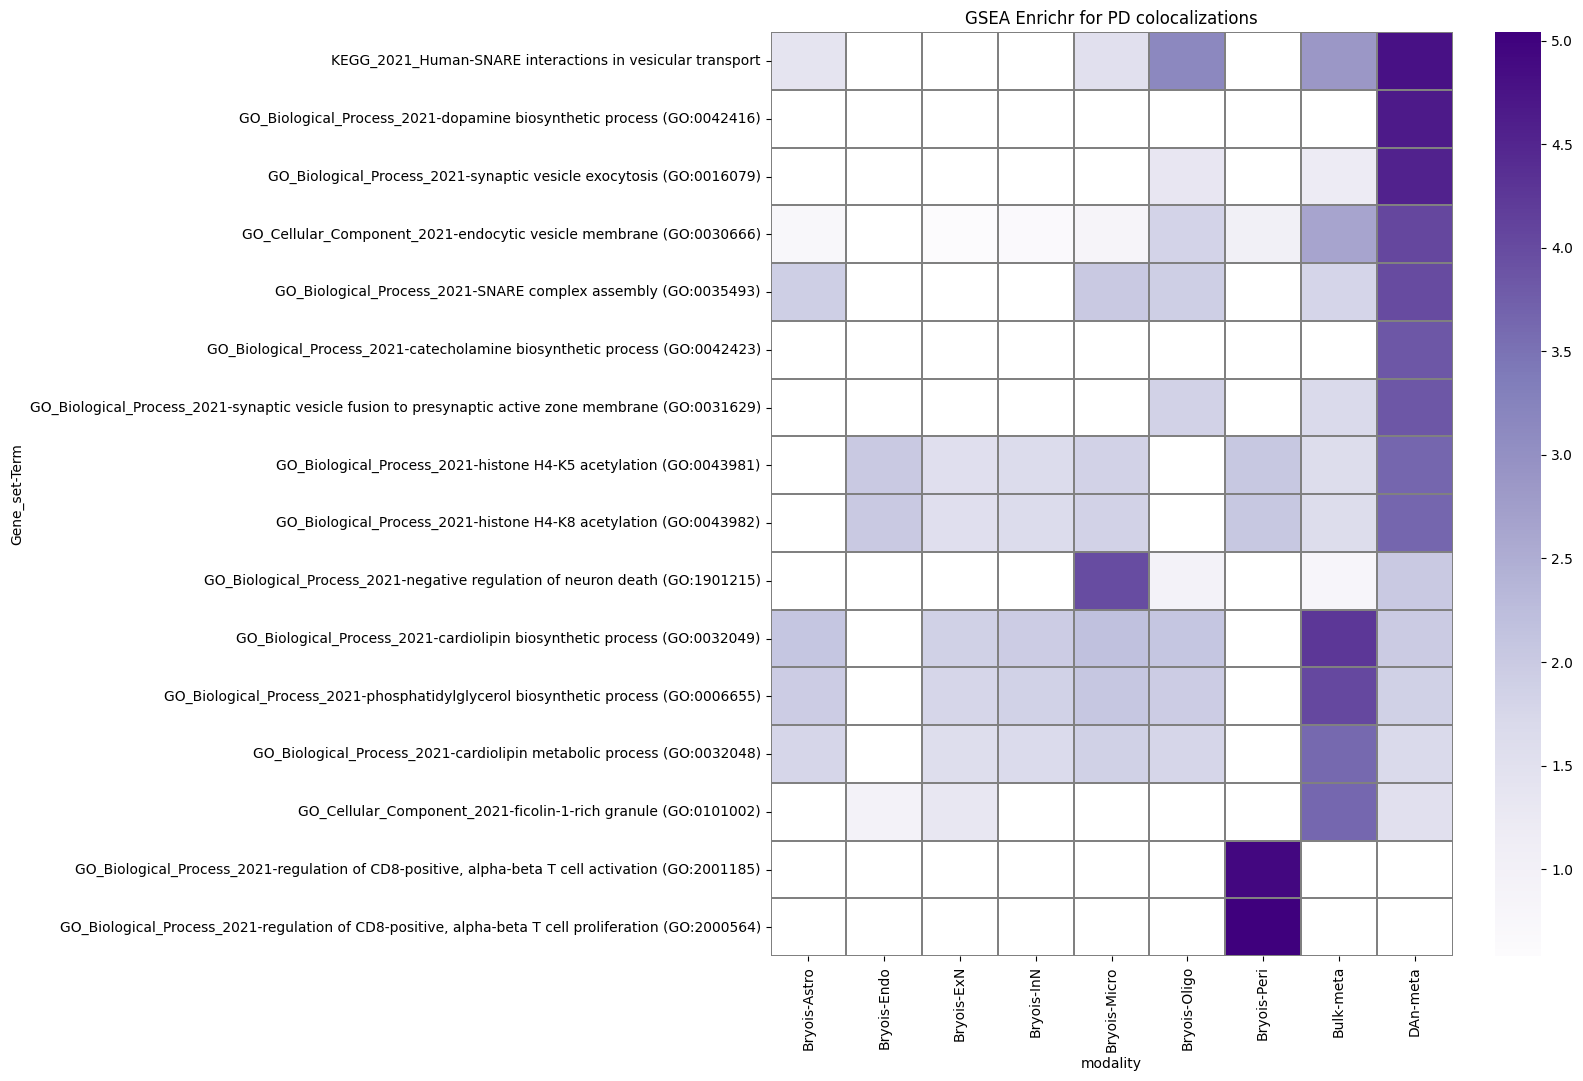

In [15]:

if wcoloc_df.shape[0] > 9:
    height = 9+ceil(wcoloc_df.shape[0]/6)
else:
    height = 9
print(height)        
with rc_context({'figure.figsize': (11, height), 'figure.dpi': 50}):
    plt.style.use('seaborn-bright')    
    heatmap(wcoloc_df, linecolor='grey', linewidths=0.05, cmap='Purples')    
    plt.title(f'GSEA Enrichr for {dx} colocalizations')
    plt.savefig(figure_file, dpi=dpi_value, bbox_inches='tight', 
                transparent=True, pad_inches=1)
    plt.show()

### visualize as clustered heatmap

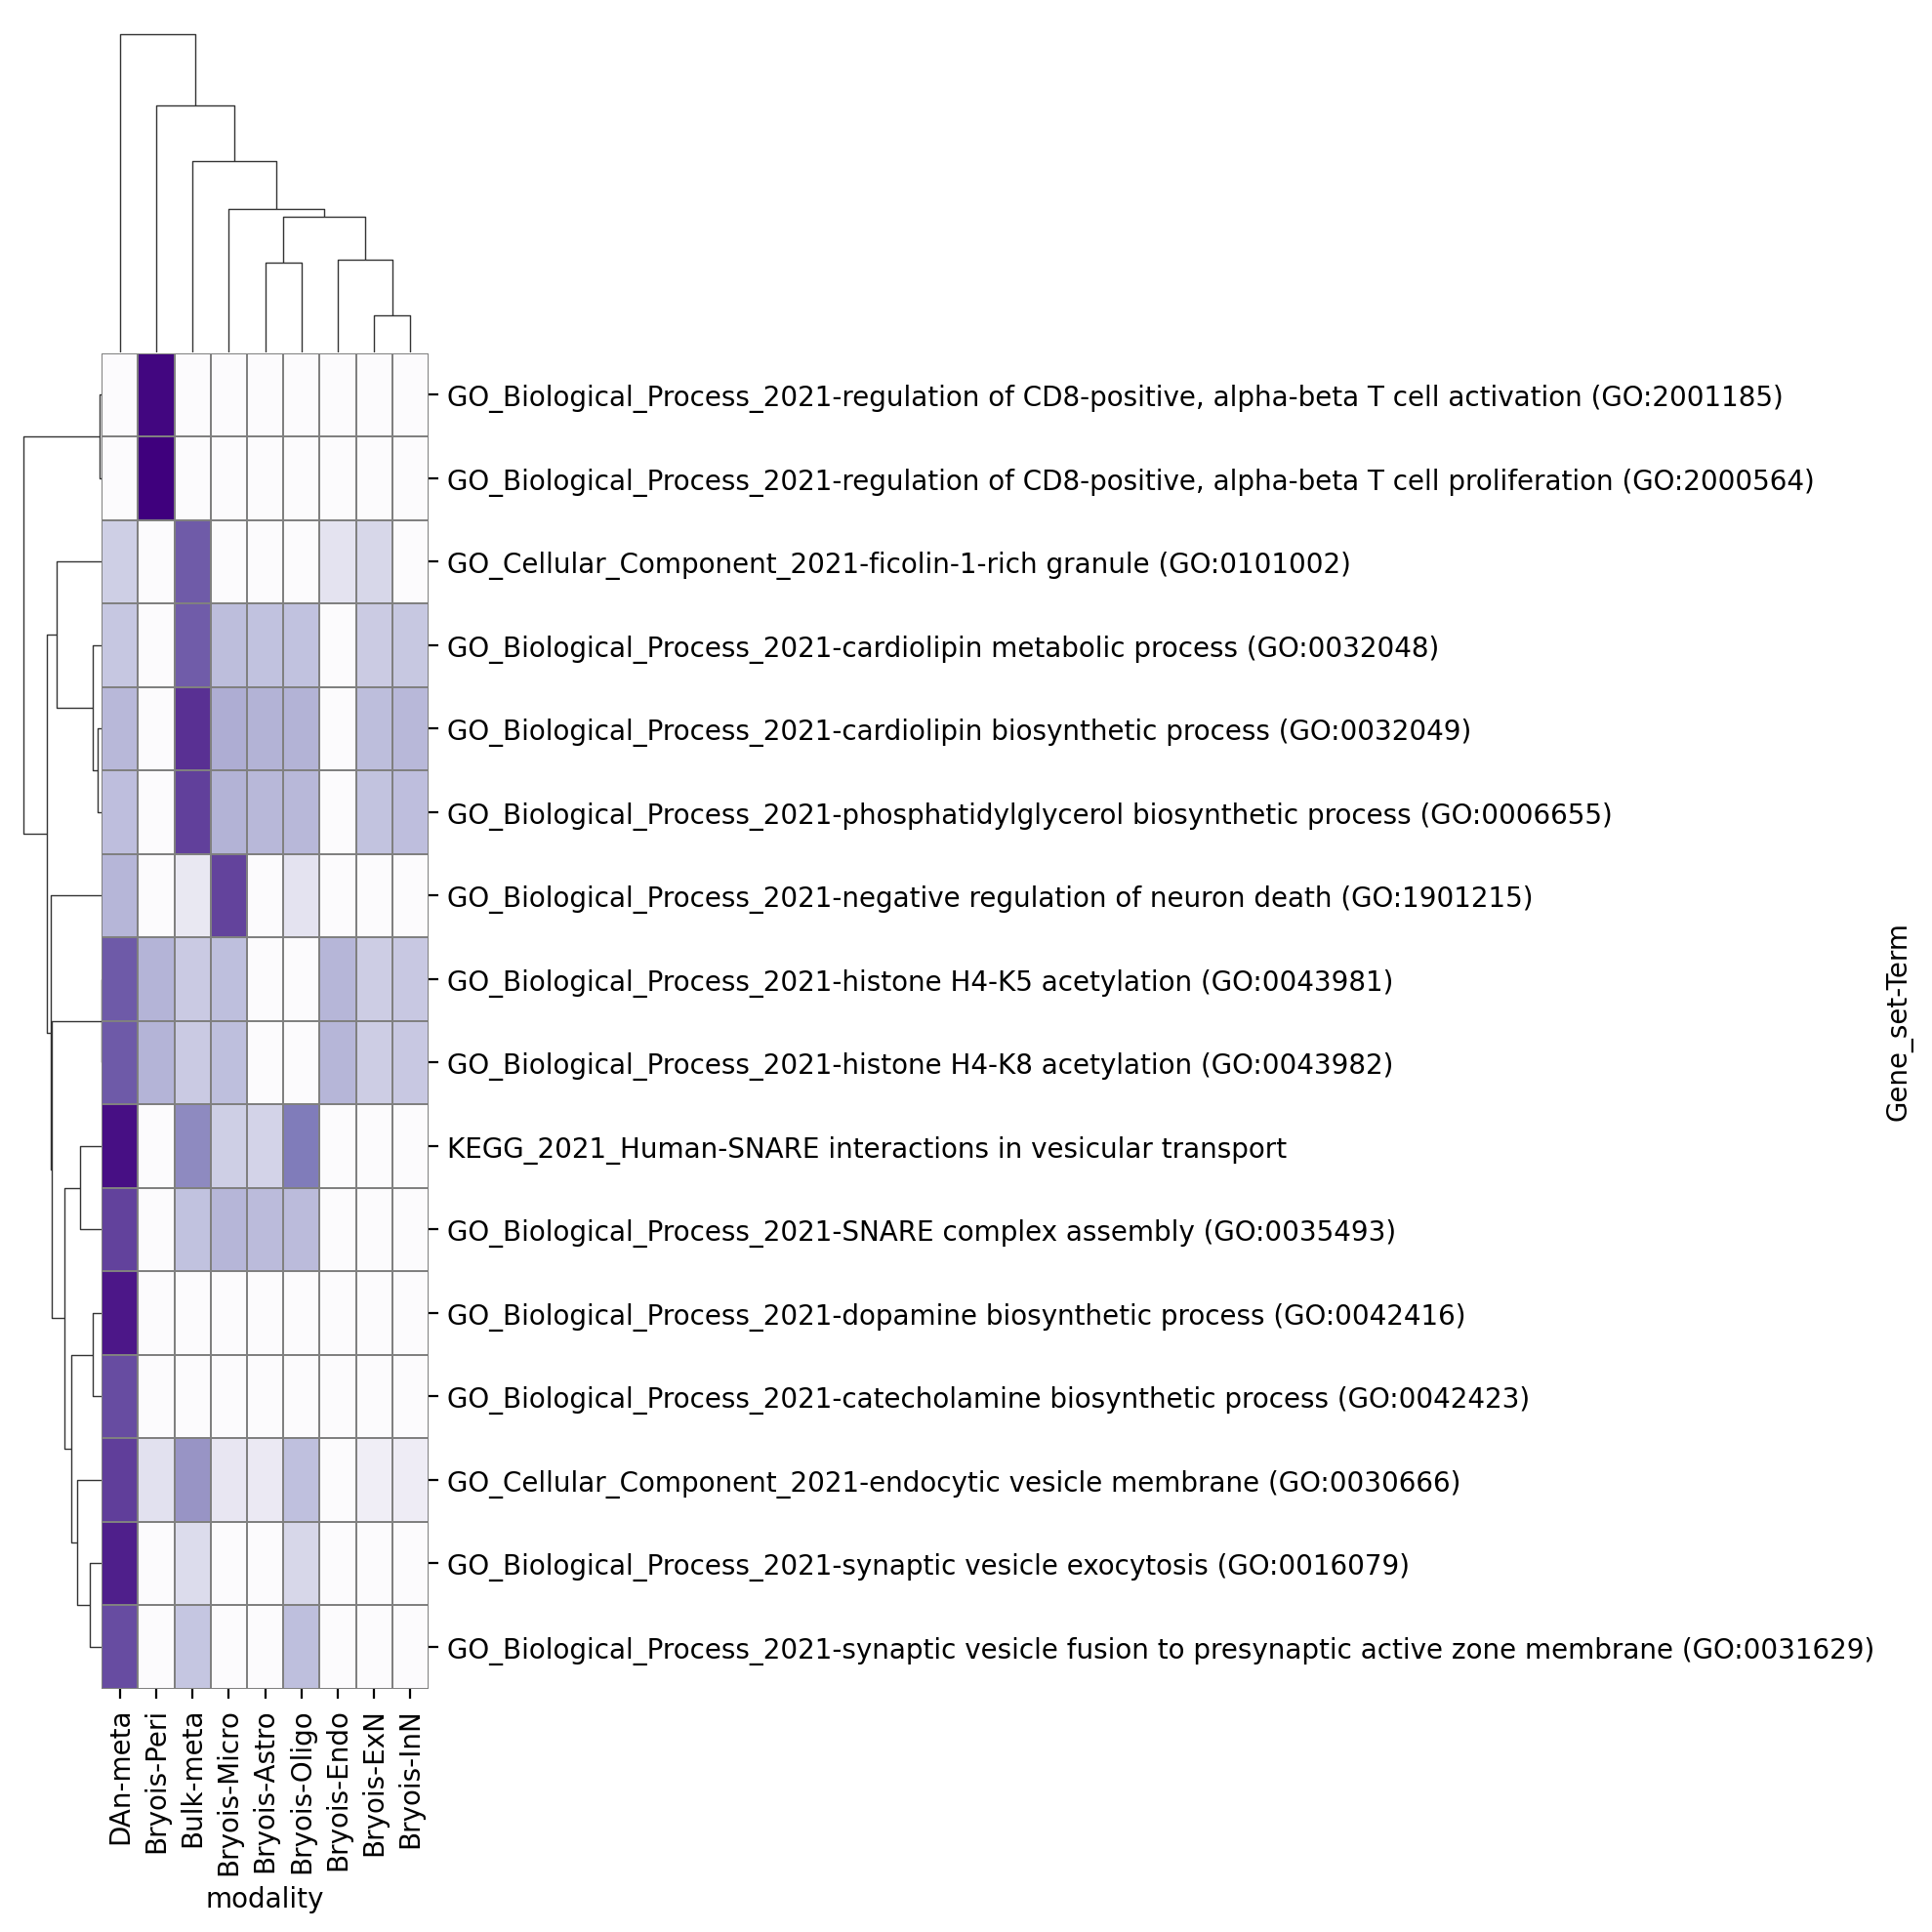

In [16]:
from seaborn import clustermap

# fill the missing
wcoloc_df = wcoloc_df.fillna(0)

with rc_context({'figure.figsize': (11, height), 'figure.dpi': 100}):
    plt.style.use('seaborn-bright')    
    # clustermap(wcoloc_df, cmap='Purples', cbar_pos=(0.75, 0.9, 0.05, 0.18))
    clustermap(wcoloc_df, cmap='Purples', cbar_pos=None, linecolor='grey', linewidths=0.05)        
    # plt.title('GSEA Enrichr')
    # plt.savefig(figure_file, dpi=dpi_value, bbox_inches='tight', 
    #             transparent=True, pad_inches=1)
    plt.show()

In [17]:
!date

Tue Feb 14 21:23:50 UTC 2023
